# A Spatial Model for COVID-19 in São Paulo City

SEIR Model:

    Susceptible -> Exposed -> Infectious -> Removed

In [1]:
%matplotlib inline
from scipy.stats import gamma 
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import numpy as np
import pandas as pd
import pyreadstat as prs
mpl.style.use('dark_background')

## Standard Epidemics Model with Discrete- Time and State Transitions

- $S_{j,t}$: Number of susceptible individuals in zone $j$ at time $t$
- $E_{j,t}$: Number of exposed individuals in zone $j$ at time $t$
- $E_{j,t}'$: Number of *new* exposed individuals in zone $j$ at time $t$
- $I_{j,t}$: Number of infectious individuals in zone $j$ at time $t$
- $I_{j,t}'$: Number of *new* infectious individuals in zone $j$ at time $t$
- $R_{j,t}$: Number of removed individuals in zone $j$ at time $t$
- $R_{j,t}'$: Number of *new* removed individuals in zone $j$ at time $t$
- $\beta_{j,t}$: infection rate for zone $j$ at time $t$
- $\gamma_{j,t}$: recovery rate (1/recovery length)
- $\sigma_{j,t}$: incubation rate (1/incubation period)

$$
S_{j,t+1} = S_{j,t} - E_{j,t+1}'
$$

$$
E_{j,t+1}' = \beta_{j,t} \frac{S_{j,t} I_{j,t}}{N_j}
$$

$$
E_{j,t+1} = E_{j,t} + E'_{j,t+1} - I'_{j,t+1}
$$

$$
I_{j,t+1}' = \sigma_{j,t} E_{j,t}, \quad I_{j,t+1} = I_{j,t} + I'_{j,t+1} - R'_{j,t+1}
$$

$$
R_{j,t+1}' = \gamma_{j,t} I_{j,t}, \quad R_{j,t+1} = R_{j,t} + R'_{j,t+1}
$$

In [2]:
# Initial conditions
length = 240 # number of days to simulate

S = np.zeros(length)
E = np.zeros(length)
I = np.zeros(length)
R = np.zeros(length)
S[0], I[0] = 51789, 10 # initial values: 10 infected, remaning susceptible
N = S[0] + E[0] + I[0] + R[0]  # total population
beta = 0.3  # transmission rate: average no. of contact times contact infectiousness
gamma = 0.1 # recovery rate = 1/recovery_period
sigma = 0.2 # 1/incubation_period

In [3]:
# Simulate
for t in range(1,length): # number of days in sinumations
    new_E = beta*S[t-1]*I[t-1]/N # newly exposed
    new_I = sigma*E[t-1]    # newly infected
    new_R = gamma*I[t-1]    # newly removed
    S[t] = S[t-1] - new_E
    E[t] = E[t-1] + new_E - new_I
    I[t] = I[t-1] + new_I - new_R
    R[t] = R[t-1] + new_R

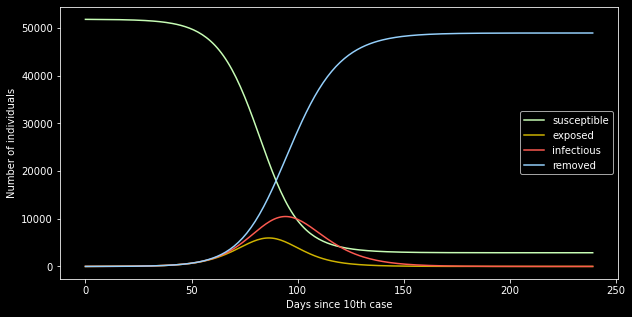

In [4]:
d = np.arange(length)
fig = plt.figure(figsize=(10,5))
plt.plot(d,S,color='xkcd:pale green',label='susceptible')
plt.plot(d,E,color='xkcd:mustard',label='exposed')
plt.plot(d,I,color='xkcd:coral',label='infectious')
plt.plot(d,R,color='xkcd:light blue',label='removed')
plt.ylabel('Number of individuals')
plt.xlabel('Days since 10th case')
plt.legend();

## Adding Spatial Information

- $p_{j,k}^t$: proportion of individuals from zone $j$ that commute to zone $k$ at day $t$


$$
E_{j,t+1}' =  \beta_{j,t}\frac{S_{j,t}I_{j,t}}{N_j} + S_{j,t} \sum_k \frac{\beta_{j,k,t} p_{k,j}^t I_{k,t}}{N_j + \sum_k p_{k,j}^t I_{k,t}}
$$



In [5]:
# Let us estimate p using data from the 2017 RMSP Origin-Destinatin survey
df, meta = prs.read_sav('../../data/raw/OD_2017.sav')
print("# of travels:", len(df))

# of travels: 183092


In [6]:
num_zones = 517
M = np.zeros((num_zones,num_zones))
for j in range(num_zones):
    for k in range(num_zones):
        M[j,k] += ((df.zona_o==j+1)&(df.zona_d==k+1)).sum()

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.imshow(M-np.diag(np.diag(M)))
plt.xlabel('Origin')
plt.ylabel('Destination');

In [ ]:
# Map zones into districts
dist_df = pd.read_csv('distritos.csv', sep=';')
num_dist = len(np.unique(dist_df.cod_distrito)) # no. of districts

In [ ]:
P = np.zeros((num_dist,num_dist))
for i in range(distritos):
    for j in range(distritos):
        P[i,j] = M[np.ix_(dist.zona[dist.cod_distrito==i+1]-1,dist.zona[dist.cod_distrito==j+1]-1)].sum()

In [ ]:
# Sanity check
P[79,66] == M[0,3] + M[1,3] + M[2,3] + M[0,4] + M[1,4] + M[2,4] + M[0,5] + M[1,5] + M[2,5]

In [ ]:
fig = plt.figure(figsize=(7,7))
im = plt.imshow(P-np.diag(np.diag(P)),vmax=200)
plt.xlabel('Origin')
plt.ylabel('Destination');
fig.colorbar(im);

In [ ]:
# Showing only the city of SP
sp_lim = int(dist_df.cod_distrito[dist_df.cod_municipio == 36].max())
P_SP = P[:sp_lim,:sp_lim]
fig, ax = plt.subplots(figsize=(10,10))
#fig = fig.figure(figsize=(7,7))
im = ax.imshow(P_SP-np.diag(np.diag(P_SP)),vmax=150)
plt.xlabel('Origin')
plt.ylabel('Destination')
#ax.set_xticks(np.arange(P_SP.shape[1]+1)-.5, minor=True)
ax.set_xticks(np.arange(0,sp_lim,3))
ax.set_xticklabels([ dist_df.distrito[dist_df.cod_distrito == i+1].unique()[0] for i in range(num_dist) ])
ax.set_yticks(np.arange(0,sp_lim,3)) #np.arange(P_SP.shape[0]+1)-.5, minor=True)
ax.set_yticklabels([ dist_df.distrito[dist_df.cod_distrito == i+1].unique()[0] for i in range(num_dist) ])
ax.tick_params(which="minor", bottom=False, left=False)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("no. of travels", rotation=-90, va="bottom")
plt.show()

In [ ]:
# Load shape files with city map and district divisions
gdf = gpd.read_file('Distrito/DEINFO_DISTRITO.shp')
# Sanity check
gdf.COD_DIST.unique().size == sp_lim

In [ ]:
# plot map
p = gdf.plot(color='white', edgecolor='black',figsize=(5,7.5));
p.axis('off');

In [ ]:
# Obtain population district -- Need to convert district names in shapes file to corresponding name in csv
from unidecode import unidecode
# List all names in csv file
names = np.unique([ s for s in dist_df.distrito.array ])
# Array of population sizes
popsizes = np.zeros(sp_lim)
# For each district name in shapes file
for i,name in enumerate(gdf.NOME_DIST.array):
    # Find equivalent name in dist_df 
    d_name = '*** not found ***'
    for dist_name in names:
        if unidecode(dist_name).upper().replace('JARDIM','JD').replace('CIDADE','CID') == name:
            d_name = dist_name
            break
    if d_name == '*** not found ***':        
        break
    # collect population size (some values are missing, 'coerce' it to NaN -- equiv. to zero when summing out)
    popsizes[i] = pd.to_numeric(dist_df.popu[dist_df.distrito == d_name],errors='coerce').sum()

gdf['POP'] = popsizes
gdf

In [ ]:
# Now plot colormap with population sizes
gdf.plot(column='POP', cmap='coolwarm', legend=True, figsize=(10, 10));
plt.title('Population');

In [ ]:
# Find row of Morumbi district
i = 0
district_names = gdf.NOME_DIST.array
while names[i] != 'MORUMBI':
    i = i + 1
s_dist = i # this will be the start of the epidemics

## Simulating the epidemics for the city of SP

In [ ]:
# Disease parameters
beta = 0.3 # transmission rate: average no. of contact times contact infectiousness
gamma = 0.1 # recovery rate = 1/recovery_period
sigma = 0.2 # 1/incubation_period
# Simulation length
length=200

In [ ]:
# Initial conditions
S = np.zeros((length,sp_lim))
E = np.zeros((length,sp_lim))
I = np.zeros((length,sp_lim))
R = np.zeros((length,sp_lim))
S[0,:] = gdf.POP # set initial no. of susceptible to population sizes
I[0,s_dist] = 10 # start with 10 infected in chosen district
S[0,s_dist] = S[0,s_dist] - I[0,s_dist]
N = S[0,:] + E[0,:]+ I[0,:] + R[0,:]  # total population in each district
print('Total population:', N.sum())
print(f'Population in district {district_names[s_dist]}:', N[s_dist])

In [ ]:
# Obtain transition probability matrix
p = np.zeros(P_SP.shape)
for j in range(sp_lim):
    for k in range(sp_lim):
        p[j,k] = P_SP[j,k]/P_SP[j,:].sum()  # discard out of city information
fig = plt.figure(figsize=(7,7))
im = plt.imshow(p)
plt.xlabel('Origin')
plt.ylabel('Destination');
fig.colorbar(im);

In [ ]:
# Simulate
for t in range(1,length): # number of days in sinumations
    #new_E = beta*S[t-1,:]*I[t-1,:]/N # newly exposed
    new_E = beta*S[t-1,:]*I[t-1,:]/N + beta*S[t-1,:]*np.dot(I[t-1,:],p[:,:])/(N + np.dot(I[t-1,:],p[:,:]))
    new_I = sigma*E[t-1,:]    # newly infected
    new_R = gamma*I[t-1,:]    # newly removed
    S[t,:] = S[t-1,:] - new_E
    E[t,:] = E[t-1,:] + new_E - new_I
    I[t,:] = I[t-1,:] + new_I - new_R
    R[t,:] = R[t-1,:] + new_R

In [ ]:
days = np.arange(length)
fig = plt.figure(figsize=(10,5))
plt.plot(days,S[:,s_dist],color='xkcd:pale green',label='susceptible')
plt.plot(days,E[:,s_dist],color='xkcd:mustard',label='exposed')
plt.plot(days,I[:,s_dist],color='xkcd:coral',label='infectious')
plt.plot(days,R[:,s_dist],color='xkcd:light blue',label='removed')
plt.ylabel('Number of individuals')
plt.xlabel('Days since 10th case')
plt.title(district_names[s_dist])
plt.legend();

In [ ]:
# Find row of Morumbi district
i = 0
district_names = gdf.NOME_DIST.array
while names[i] != 'BRASILANDIA':
    i = i + 1
i # this will be the start of the epidemics
fig = plt.figure(figsize=(10,5))
plt.plot(days,S[:,i],color='xkcd:pale green',label='susceptible')
plt.plot(days,E[:,i],color='xkcd:mustard',label='exposed')
plt.plot(days,I[:,i],color='xkcd:coral',label='infectious')
plt.plot(days,R[:,i],color='xkcd:light blue',label='removed')
plt.ylabel('Number of individuals')
plt.xlabel('Days since 10th case')
plt.title(district_names[i])
plt.legend();

In [ ]:
fig, axes = plt.subplots(sp_lim//6,6,sharex='all',sharey='all',figsize=(3*6,3*sp_lim//6))
for i,ax in enumerate(axes.flat):
        ax.plot(days,100*I[:,i]/N[i],color='xkcd:coral',label='infectious')
        ax.set_title(district_names[i])
#axes[0][0].legend()
axes[0][0].set_ylabel('% of Infected Individuals')
axes[0][0].set_xlabel('Days Since 10th Case')
#fig.text(0.06, 0.5, '% of Infected Individuals', ha='center', va='center', rotation='vertical')
#fig.text(0.5, -0.05, 'Days since 10th case', ha='center', va='center')
plt.ylabel('% of Infected Individuals')
plt.xlabel('Days Since 10th Case')
#plt.tick_params(labelcolor='none', top='False', bottom='False', left='False', right='False')
fig.tight_layout();

In [ ]:
# Show colormap with proportion of infecteds at given day
d = 50
gdf['infected'] = 100*I[d,:]/N
gdf.plot(column='infected', cmap='coolwarm', legend=True, figsize=(10, 10));
plt.title(f'% Infected at Day {d}');

In [ ]:
# Show colormap with proportion of infecteds at given day
d = 100
gdf['infected'] = 100*I[d,:]/N
gdf.plot(column='infected', cmap='coolwarm', legend=True, figsize=(10, 10));
plt.title(f'% Infected at Day {d}');

In [ ]:
# Show colormap with proportion of infecteds at given day
d = 150
gdf['infected'] = 100*I[d,:]/N
gdf.plot(column='infected', cmap='coolwarm', legend=True, figsize=(10, 10));
plt.title(f'% Infected at Day {d}');